In [1]:
import numpy as np
from scipy.stats import norm
import statsmodels.stats.api as sms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

## Hormone data

In [78]:
df = pd.read_csv('horm_sort.csv', usecols = [0,1,2,3])
df[['Testosterone']]= df[['Testosterone']].apply(pd.to_numeric, errors='coerce')
df.rename(columns={"Subjects": "ID"}, inplace = True)
h_df = df.groupby(['Time','Type','ID'])['Testosterone'].min().unstack().T
h_df.columns = ['Pl_T0','T_T0','Pl_T1','T_T1']
h_df.loc['MR24','Pl_T0'] = h_df.loc['MR24','Pl_T1'] 
h_df.loc['MR25','T_T1'] = h_df[h_df['Pl_T0'].between(18, 25)]['T_T1'].mean()
h_df['Pl_change'] = (h_df['Pl_T1']-h_df['Pl_T0'])/h_df['Pl_T0']
h_df['T_change'] = (h_df['T_T1']-h_df['T_T0'])/h_df['T_T0']
h_df['TPl_change'] = (h_df['T_T1']-h_df['Pl_T1'])/h_df['Pl_T1']
TPl_change = h_df.TPl_change
TPl_change['MR23'] = TPl_change.mean()
#TPl_change
ids = pd.read_excel('EE_subj_list.xlsx', header=None, usecols = [1,2])
ids.columns = ['ID', 'Subjects']
ids = ids.join(TPl_change, on = ['ID'])

## Endowment data

In [92]:
df = pd.read_excel('Endowment_list.xlsx')
df1 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTA_Test','WTA_Plac'], value_name='WTA')
df1['Test'] = 0
df1.loc[df1.variable.str.contains('Test'),'Test'] = 1
df1.drop('variable', axis=1, inplace = True)
df2 = pd.melt(df, id_vars=['Subjects','Item','Type','Market Price'], value_vars=['WTP_Test','WTP_Plac'], value_name='WTP')
df2['Test'] = 0
df2.loc[df2.variable.str.contains('Test'),'Test'] = 1
df2.drop('variable', axis=1, inplace = True)
df = df1.merge(df2)
df.drop(df.index[(df.WTA.isin([0, np.nan])) | (df.WTP.isin([0, np.nan]))], inplace = True)
df['WTA/WTP'] = df.WTA/df.WTP
df = pd.merge(df, ids, on = 'Subjects')
df.loc[df.Test==0, 'TPl_change'] = 0
df = df.drop(['Market Price','WTA','WTP','ID'],axis=1)

In [93]:
df = df[~ df.Subjects.isin(['Subj33','Subj35'])].reset_index(drop=True)

In [94]:
df

,Subjects,Item,Type,Test,WTA/WTP,TPl_change
0,Subj1,gin,h,1,1.000000,2.655172
1,Subj1,beer set,h,1,1.500000,2.655172
2,Subj1,video game,h,1,1.000000,2.655172
3,Subj1,helicopter,h,1,1.333333,2.655172
4,Subj1,car model,h,1,1.250000,2.655172
...,...,...,...,...,...,...
1966,Subj38,outdoor lamp,u,0,3.000000,0.000000
1967,Subj38,buff,u,0,3.000000,0.000000
1968,Subj38,sports glasses,u,0,3.750000,0.000000
1969,Subj38,smart LED,u,0,1.000000,0.000000


There are number of outliers in the data, when WTA exceed WTP 20 times and more. We decided to clip these values to the reasonable upper boarder equal to mean value with 3 standart deviations added

In [95]:
max_rel = df['WTA/WTP'].mean()+3*df['WTA/WTP'].std()
df['WTAPcorr'] = df['WTA/WTP']
df.loc[df['WTA/WTP']>max_rel,'WTAPcorr'] = max_rel

In [96]:
df["ItemCodes"] = pd.Categorical(df['Item']).codes
df["SubjectsCode"] = pd.Categorical(df['Subjects']).codes
df["TypeCode"] = pd.Categorical(df['Type']).codes

In [97]:
df.head()

,Subjects,Item,Type,Test,WTA/WTP,TPl_change,WTAPcorr,ItemCodes,SubjectsCode,TypeCode
0,Subj1,gin,h,1,1.000000,2.655172,1.000000,8,0,0
1,Subj1,beer set,h,1,1.500000,2.655172,1.500000,1,0,0
2,Subj1,video game,h,1,1.000000,2.655172,1.000000,26,0,0
3,Subj1,helicopter,h,1,1.333333,2.655172,1.333333,10,0,0
4,Subj1,car model,h,1,1.250000,2.655172,1.250000,6,0,0


## General comparison hedonic and utilitarian goods

From the picture we can see little difference between hedonic and utilitarian goods

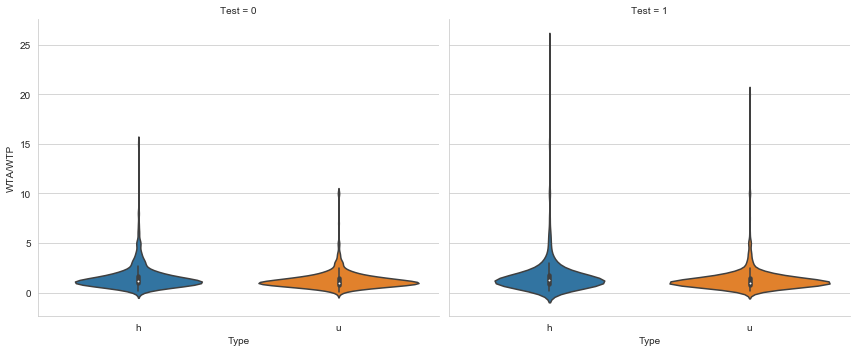

In [98]:
g = sns.catplot(x="Type", y="WTA/WTP",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);

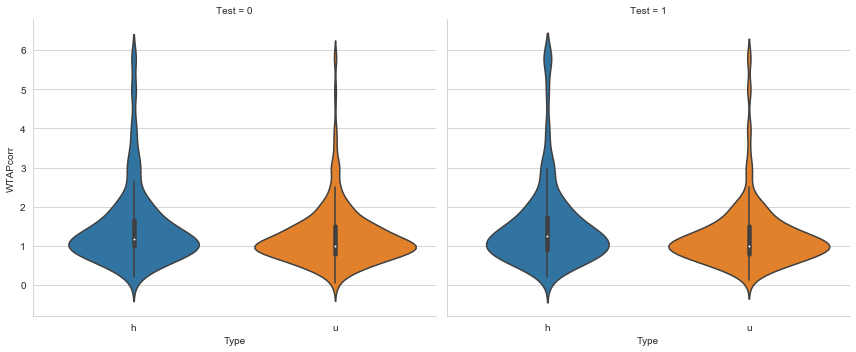

In [99]:
g = sns.catplot(x="Type", y="WTAPcorr",
                col="Test",
                data=df, kind="violin",
                height=5, aspect=1.2);

Which one is better? I prefer the last one, but you can change below

In [100]:
df.groupby(['Type','Test'])['WTA/WTP','WTAPcorr'].agg(['mean','std'])

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


WTA/WTP            WTAPcorr          
               mean       std      mean       std
Type Test                                        
h    0     1.545884  1.256945  1.512510  1.046627
     1     1.685594  2.051031  1.533228  1.104491
u    0     1.275525  0.919314  1.255944  0.769486
     1     1.320956  1.281535  1.271875  0.847193

There is a small problem with the equal variance assumption here. Variance assuming equal variance in both data sets, but here it is violated

In [101]:
cm = sms.CompareMeans(sms.DescrStatsW(df.loc[(df.Test == 0)&(df.Type == 'h'),'WTAPcorr'].values), sms.DescrStatsW(df.loc[(df.Test == 0)&(df.Type == 'u'),'WTAPcorr'].values))
cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.2566,0.059,4.367,0.000,0.141,0.372


In [102]:
cm = sms.CompareMeans(sms.DescrStatsW(df.loc[(df.Test == 1)&(df.Type == 'h'),'WTAPcorr'].values), sms.DescrStatsW(df.loc[(df.Test == 1)&(df.Type == 'u'),'WTAPcorr'].values))
cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.2614,0.062,4.188,0.000,0.139,0.384


In both conditions there is difference between type of goods.
We can draw nice pictures from Bayesian perspective, and it is not sensitive to equal variance assumption

### Placebo condition

In [103]:
with pm.Model() as model_pl:
    
    df_sel = df[df.Test==0].reset_index()
    mean = pm.Normal('mean', mu=df_sel.WTAPcorr.mean(), sd=2*df_sel.WTAPcorr.std(),  shape=(2,))
    sigma = pm.HalfCauchy('sd', beta=10, shape=(2,))
    WTAP = pm.Normal('WTAP', mu=mean[df_sel['TypeCode'].values], sd=sigma[df_sel['TypeCode'].values], observed=df_sel['WTA/WTP'].values)

    trace_pl = pm.sample(4000, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 18000/18000 [00:03<00:00, 4660.08draws/s]


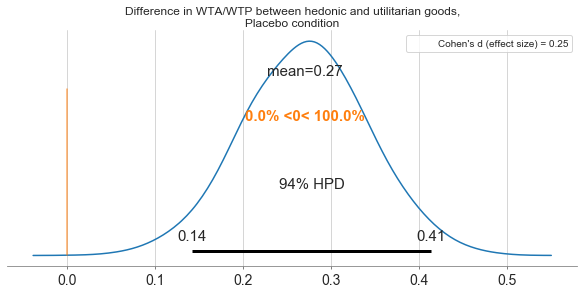

In [104]:
def effect_size(trace, condition = 'Placebo'):
    means_diff = trace['mean'][:, 0] - trace['mean'][:, 1]
    d_cohen = (means_diff / np.sqrt((trace['sd'][:, 0]**2 +
    trace['sd'][:, 1]**2) / 2)).mean()
    _, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
    az.plot_posterior(means_diff, ref_val=0, ax=ax)
    ax.set_title(f'Difference in WTA/WTP between hedonic and utilitarian goods,\n {condition} condition')
    ax.plot(0, label=f"Cohen's d (effect size) = {d_cohen:.2f}",alpha=0)
    ax.legend();
effect_size(trace_pl)    

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/data/base.py:146: UserWarning: More chains (16000) than draws (2). Passed array should have shape (chains, draws, *shape)
  UserWarning,


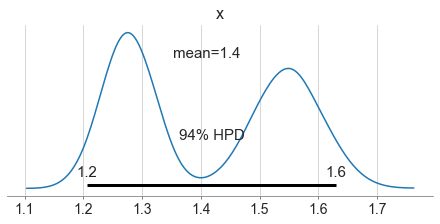

In [105]:
az.plot_posterior(trace_pl['mean']);

There is difference but effect size is small (for values below 0.5 effects is considered as a small)

### Under testosterone

In [106]:
with pm.Model() as model_test:
    
    df_sel = df[df.Test==1].reset_index()
    mean = pm.Normal('mean', mu=df_sel.WTAPcorr.mean(), sd=2*df_sel.WTAPcorr.std(),  shape=(2,))
    sigma = pm.HalfCauchy('sd', beta=10, shape=(2,))
    WTAP = pm.Normal('WTAP', mu=mean[df_sel['TypeCode'].values], sd=sigma[df_sel['TypeCode'].values], observed=df_sel['WTA/WTP'].values)

    trace_test = pm.sample(4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:04<00:00, 4778.16draws/s]


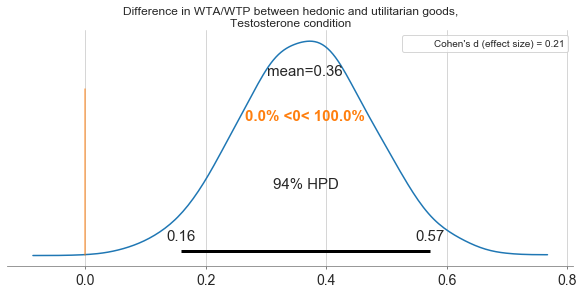

In [107]:
effect_size(trace_test, condition = 'Testosterone')    

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/data/base.py:146: UserWarning: More chains (16000) than draws (2). Passed array should have shape (chains, draws, *shape)
  UserWarning,


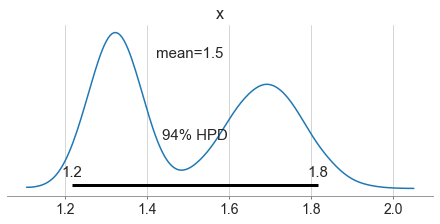

In [108]:
az.plot_posterior(trace_test['mean']);

## Testosterone related shift exploration
We can test existence of testosterone shift with the paired t-test, but we can do better, with the linear model and take into account item differences and individual differences

**Models**

 - model 0 (baseline model, without testosterone splitting): WTA/WTP relationship is individual for each item and described with Normal distribution with some parameters  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 
 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(mu, 5), sigma_{item} \sim HalfCauchy(0,1)$$
 
 - model 1 (model with additional testosterone condition, binary testosterone value): WTA/WTP relationship is individual for each item and described with Normal distribution with some parameters  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
  $$\mu_{item} \sim mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(mu, 5), bT \sim Normal(0,1), \sigma_{item} \sim HalfCauchy(0,1)$$
 
 - model 2 (model with additional testosterone condition, magnitude of change): WTA/WTP relationship is individual for each item and described with Normal distribution with some parameters  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma_{item})$$
  $$\mu_{item} \sim mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(\mu, 5), bT \sim Normal(0,1), \sigma_{item} \sim HalfCauchy(0,1)$$
 
 - model 3 (model with additional testosterone condition, magnitude of change, and individual differences (sigma)): WTA/WTP relationship is individual for each item and described with Normal distribution with some parameters  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma)$$
  $$\mu_{item} \sim mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(\mu, 5), bT \sim Normal(0,1)$$
 

$$ \sigma = \sigma_{item}+sigma_ind, \sigma_{item} \sim HalfCauchy(0,1), \sigma_{ind} \sim HalfCauchy(0,1)$$

- model 4 (model with additional testosterone condition, magnitude of change, and individual differences (mu and sigma)): WTA/WTP relationship is individual for each item and described with Normal distribution with some parameters  
 $$WTA/WTP_{item} \sim Normal(\mu_{item},\sigma)$$
  $$\mu_{item} \sim \mu_{ind}+\mu_{item}+bT*Testosterone$$
 with priors for each item, here 2-level model, we assume that there is general distribution for WTA/WTP and individual values inherited from it: 

 $$\mu  \sim Normal(1, 5), \mu_{item} \sim Normal(\mu, 5), bT \sim Normal(0,1)$$
 

$$ \sigma = \sigma_{item}+sigma_ind, \sigma_{item} \sim HalfCauchy(0,1), \sigma_{ind} \sim HalfCauchy(0,1)$$

In the last model, we assume that there is individual WTA/WTP mean, this is strange, but likelihood became better

 
 



 




In [109]:
n_items = len(pd.unique(df.ItemCodes))
n_inds = len(pd.unique(df.SubjectsCode))

In [110]:
with pm.Model() as model_0:  
   
    mu  = pm.Normal('mu', 1, 5)

    mu_item  = pm.Normal('mu_item', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    
    WTAP = pm.Normal('WTAP', mu=mu_item[df.ItemCodes.values], sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_0 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,640.2:   8%|▊         | 15299/200000 [00:05<01:09, 2663.70it/s]
Convergence achieved at 15300
Interrupted at 15,299 [7%]: Average Loss = 3,043.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_item, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:04<00:00, 2288.20draws/s]


In [111]:
az.waic(trace_0)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 1971 log-likelihood matrix

          Estimate       SE
elpd_waic -2545.55    68.03
p_waic      123.08        -

There has been a warning during the calculation. Please check the results.

In [112]:
def plot_bars(df, name_coeff = 'mu_item', trace = trace_0, x_line = trace_0['mu'].mean(), xlim = [0.8,2.5], tname = 'Individual WTA/WTP values and credible intervals for ', label = 'Overall mean WTA/WTP'):
    coeff = trace[name_coeff]
    coeff_hpd = pm.hpd(coeff)
    res_df = pd.DataFrame(df.groupby(['Item'])['ItemCodes'].min()).reset_index()
    res_df[name_coeff] = coeff.mean(0)
    res_df[name_coeff+'_low'] = coeff_hpd.T[0]
    res_df[name_coeff+'_up'] = coeff_hpd.T[1]
    type_df = pd.DataFrame(df.groupby('Item')['Type'].min()).reset_index()
    res_df = pd.merge(res_df,type_df)
    list_items = [res_df[res_df.Type == 'h'].reset_index(drop=True), res_df[res_df.Type == 'u'].reset_index(drop=True)]
    fig, ax  = plt.subplots(ncols=2, figsize=(16,6))
    for i in range(2):
        idx = np.argsort(list_items[i][name_coeff])
        y_label = list_items[i].loc[idx,'Item']
        y_points = np.linspace(0, 1, len(idx))
        x = list_items[i].loc[idx,name_coeff].values
        xerr = np.abs(np.array([list_items[i].loc[idx,name_coeff+'_low'].values,list_items[i].loc[idx,name_coeff+'_up'].values])-x)
        ax[i].errorbar(x,y_points,xerr = xerr,fmt='C0o', lw=3, alpha=0.5, mfc = 'purple')
        ax[i].set_yticks(y_points);
        ax[i].set_yticklabels(y_label);
        ax[i].set_xlim(xlim[0],xlim[1])
        ax[i].vlines(x_line, 0, 1, 'grey', label = label);
        gtype = ['hedonic', 'utilitarian']
        ax[i].legend()
        ax[i].set_title(f'{tname}{gtype[i]} goods', fontsize = 14)

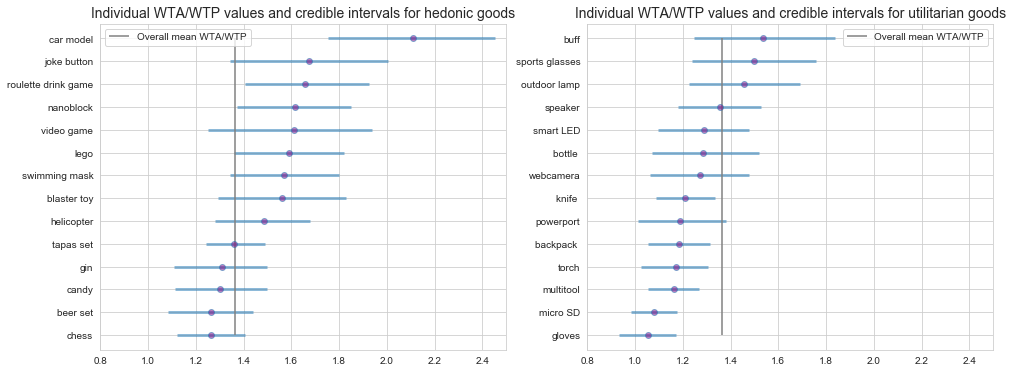

In [113]:
plot_bars(df, name_coeff = 'mu_item', trace = trace_0, x_line = trace_0['mu'].mean())

In [114]:
with pm.Model() as model_1:  
    
    mu  = pm.Normal('mu', 1, 5)

    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)


    mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.Test.values)

    
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_1 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,686.4:   8%|▊         | 16999/200000 [00:08<01:27, 2096.41it/s]
Convergence achieved at 17000
Interrupted at 16,999 [8%]: Average Loss = 3,124.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigma, alpha, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:09<00:00, 1082.55draws/s]


In [115]:
az.waic(trace_1)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 1971 log-likelihood matrix

          Estimate       SE
elpd_waic -2563.01    67.23
p_waic      146.88        -

There has been a warning during the calculation. Please check the results.

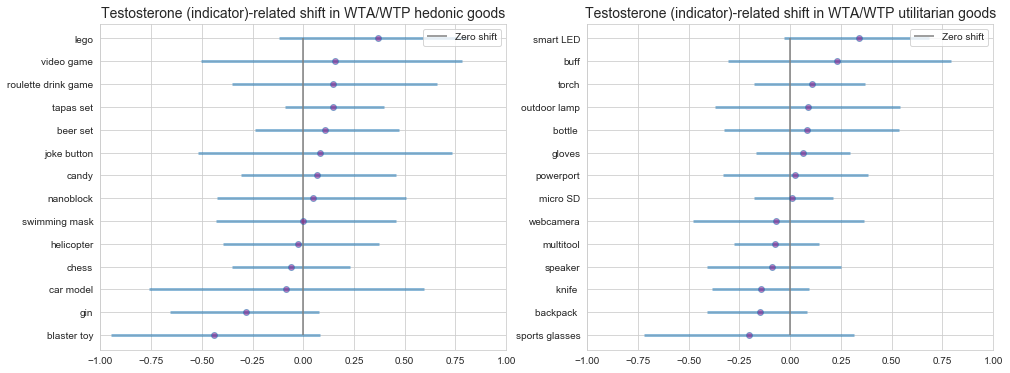

In [116]:
plot_bars(df, name_coeff = 'bT', trace = trace_1, x_line = 0, xlim = [-1,1], tname = 'Testosterone (indicator)-related shift in WTA/WTP ', label = 'Zero shift')

In [117]:
with pm.Model() as model_2:  
    
    mu  = pm.Normal('mu', 1, 5)
    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)
    mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values], observed=df['WTAPcorr'].values)
    trace_2 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,684.3:   9%|▊         | 17299/200000 [00:08<01:24, 2153.51it/s]
Convergence achieved at 17300
Interrupted at 17,299 [8%]: Average Loss = 3,131.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bT, sigma, alpha, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:07<00:00, 1380.00draws/s]


In [ ]:
az.waic(trace_2)

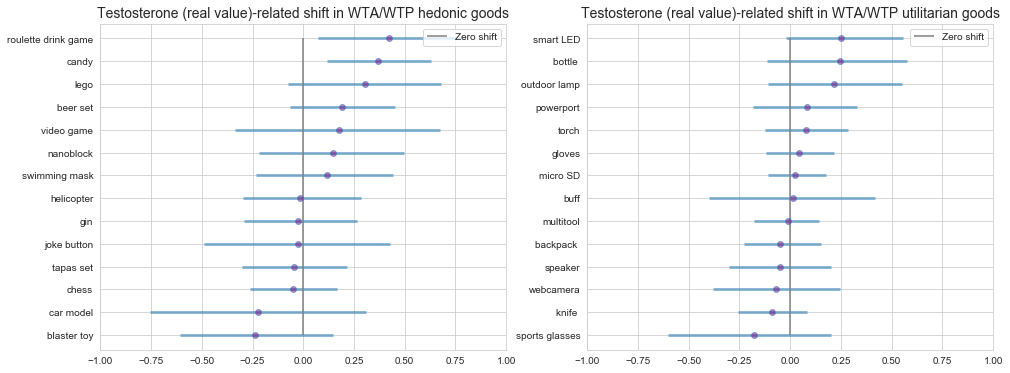

In [42]:
plot_bars(df, name_coeff = 'bT', trace = trace_2, x_line = 0, xlim = [-1,1], tname = 'Testosterone (real value)-related shift in WTA/WTP ', label = 'Zero shift')

In [57]:
with pm.Model() as model_3:  
    mu  = pm.Normal('mu', 1, 5)
    #a_ind  = pm.Normal('alpha_ind', 0, sd = 1, shape = n_inds)
    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)
    #mu_item  = pm.Deterministic('mu_item', a_ind[df.SubjectsCode.values]+a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)
    mu_item  = pm.Deterministic('mu_item', a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)

    sigmaInd = pm.HalfCauchy('sigmaInd', beta = 0.5, shape = n_inds)
    
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values]+sigmaInd[df.SubjectsCode.values], observed=df['WTAPcorr'].values)
    trace_3 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,683.2:   9%|▉         | 18499/200000 [00:13<02:14, 1347.12it/s]
Convergence achieved at 18500
Interrupted at 18,499 [9%]: Average Loss = 2,978.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigmaInd, bT, sigma, alpha, mu]
Sampling 4 chains, 1 divergences: 100%|██████████| 10000/10000 [00:11<00:00, 889.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [58]:
az.waic(trace_3)

/Users/irinaknyazeva/opt/anaconda3/envs/py36/lib/python3.6/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 6000 by 2057 log-likelihood matrix

          Estimate       SE
elpd_waic -2510.95    69.18
p_waic      196.21        -

There has been a warning during the calculation. Please check the results.

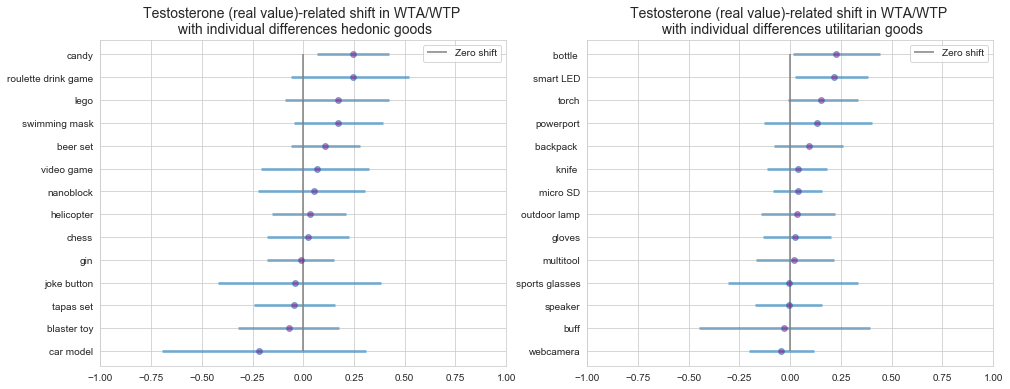

In [59]:
plot_bars(df, name_coeff = 'bT', trace = trace_3, x_line = 0, xlim = [-1,1], tname = 'Testosterone (real value)-related shift in WTA/WTP \n with individual differences ', label = 'Zero shift')

In [60]:
with pm.Model() as model_4:  
    mu  = pm.Normal('mu', 1, 5)
    a_ind  = pm.Normal('alpha_ind', 0, sd = 1, shape = n_inds)
    a_item  = pm.Normal('alpha', mu = mu, sd = 5, shape = n_items)
    sigma = pm.HalfCauchy('sigma', beta = 1, shape = n_items)
    bT = pm.Normal('bT', mu = 0, sd = 1, shape = n_items)
    mu_item  = pm.Deterministic('mu_item', a_ind[df.SubjectsCode.values]+a_item[df.ItemCodes.values]+bT[df.ItemCodes.values]*df.TPl_change.values)

    sigmaInd = pm.HalfCauchy('sigmaInd', beta = 0.5, shape = n_inds)
    
    WTAP = pm.Normal('WTAP', mu=mu_item, sd=sigma[df.ItemCodes.values]+sigmaInd[df.SubjectsCode.values], observed=df['WTAPcorr'].values)
    trace_4 = pm.sample(2000, tune=500, init= 'advi')[500:]

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 2,483.5:  10%|█         | 20299/200000 [00:10<01:35, 1883.76it/s]
Convergence achieved at 20300
Interrupted at 20,299 [10%]: Average Loss = 2,890.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigmaInd, bT, sigma, alpha, alpha_ind, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:13<00:00, 740.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


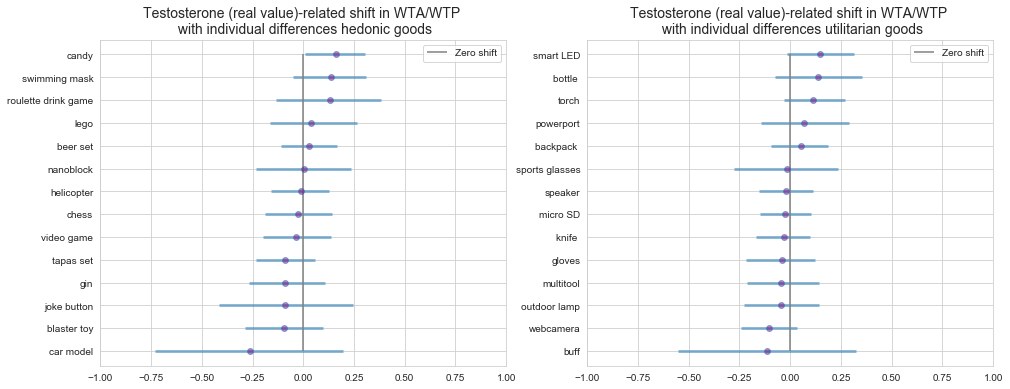

In [61]:
plot_bars(df, name_coeff = 'bT', trace = trace_4, x_line = 0, xlim = [-1,1], tname = 'Testosterone (real value)-related shift in WTA/WTP \n with individual differences ', label = 'Zero shift')